In [196]:
VERSION

v"1.10.5"

In [197]:
] activate .

  Activating new project at `~/TRIXI`


In [198]:
using OrdinaryDiffEq
using Trixi
using Plots

# Nonlinear Kerr Effect

This notebook describes how to use `Trixi.jl` to simulate the Slowly-Varying-Envelope-Approximation (SVEA) and Paraxial Wave Equations for a guassian beam including optical absorption and the nonlinear Kerr effect.

This notebook is based off the previous notebook for the SVEA Paraxial wave equation and many things will be reused. 

# Adding Longitudinal Dispersion and Nonlinear Instantaneous Refractive Index (Kerr Effect)

In the previous notebook, we used the textbook *Fundamentals of Nonlinear Optics* by Powers. We start from the same equation. The numbers of these equations will continue from the previous notebook.

The full time dependent paraxial wave equation is given by Equation 10.79 in Powers: 

\begin{equation}
    \frac{\partial}{\partial t} A + \frac{i v_{g}}{2 k_{0} v_{g}^{2}} \left. \left( 1 - k_{0} \frac{\partial v_{g}}{\partial \omega}  \right)\right|_{\omega_{0}} \frac{\partial^2}{\partial t^2} A  + v_{g} \frac{\partial}{\partial z} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A = \frac{i \mu_{0} \omega_{0}^{2}}{2 k_{0}} P_{NL} e^{- i k_{0} z} 
    \tag{20}
\end{equation}

In Boyd's textbook, Equation 7.5.23, the group velocity dispersion (which is usually labeled as either $\kappa_2$ or $\beta_{2}$ ) is given by: 

\begin{equation}
    \begin{aligned}
    \kappa_{2} &= \left. \left( \frac{d^{2} k}{d \omega^{2}} \right) \right|_{\omega = \omega_{0}} \\
    &= \frac{d}{d \omega} \left. \left( \frac{1}{v_{g}\left(  \omega \right)}   \right) \right|_{\omega = \omega_{0}} \\
    &= \left. \left( \frac{1}{v_{g}^{2}\left(  \omega \right)}  \frac{d v_{g}\left(  \omega \right)}{d \omega} \right)  \right|_{\omega = \omega_{0}}
    \end{aligned}
\end{equation}

We can add optical absorption and Kerr effect:

\begin{equation}
    \frac{\partial}{\partial t} A + \frac{i}{2 k_{0} v_{g}}\left( 1 - k_{0} v_{g}^{2} \kappa_{2}  \right)  \frac{\partial^2}{\partial t^2} A + \frac{\alpha}{2} A  + v_{g} \frac{\partial}{\partial z} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A = i k_{0} n_{2} I A
    \tag{21}
\end{equation}

But we'll make the substitution for the full velocity dispersion with $\beta_{2}$:

\begin{equation}
    \frac{\partial}{\partial t} A + \frac{i}{2}\beta_{2}  \frac{\partial^2}{\partial t^2} A  + v_{g} \frac{\partial}{\partial z} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A = -\frac{\alpha v_{g}}{2} A + i k_{0} v_{g} n_{2} I A
    \tag{22}
\end{equation}

where $n_{2}$ is the instantaneous second order nonlinear refractive index. More can be found in Boyd and this wikipedia article: https://en.wikipedia.org/wiki/Kerr_effect

We put the optical absorption (extinction coefficient term) and the nonlinear Kerr effect on the RHS because we will use `Trixi.jl` function for source terms.

The intensity $I$ is:

\begin{equation}
    \begin{aligned}
    I &= \frac{v_{p} \epsilon_{0} \epsilon_{r} \mu_{r} }{2} \left| E \right|^{2} = \frac{c \epsilon_{0} n}{2}\left| E \right|^{2} \\
    &= \frac{c \epsilon_{0}}{2} \sqrt{\frac{\epsilon_{r}}{\mu_{r}}} \;\;\left| E \right|^{2}
    \end{aligned}
\end{equation}

in SI units. In CGS units the formula is: 

\begin{aligned}
    I = \frac{c}{8 \pi} \sqrt{\frac{\epsilon_{r}}{\mu_{r}}}  \;\; \left| E \right|^{2}
\end{aligned}

We need to set this up into single derivatives in time so we have to re-write this with the following substitutions:

\begin{equation}
    \begin{aligned}
    B = \partial_{t} A
    \end{aligned}
\end{equation}

Then our equation becomes a coupled system: 

\begin{equation}
    \begin{aligned}
    \frac{i}{2}\beta_{2}  \frac{\partial}{\partial t} B  + v_{g} \frac{\partial}{\partial z} A - i\frac{v_{g}}{2 k_{0}} \nabla^{2} A &= - B -\frac{\alpha v_{g}}{2} A + i k_{0} v_{g} n_{2} I A \\
    \partial_{t} A &= B
    \end{aligned}
    \tag{23}
\end{equation}



and dividing through by $\frac{i}{2}\beta_{2} $ :

\begin{equation}
    \begin{aligned}
    \frac{\partial}{\partial t} B  - i  \frac{2 v_{g}}{\beta_{2}} \frac{\partial}{\partial z} A - \frac{v_{g}}{ k_{0} \beta_{2}} \nabla^{2} A &= i\frac{2}{\beta_{2}} B + i \frac{\alpha v_{g}}{\beta_{2}} A + \frac{ 2 k_{0} v_{g} n_{2}}{\beta_{2}} I A \\
    \partial_{t} A &= B
    \end{aligned}
    \tag{23}
\end{equation}

Again, this needs to be split into the real and imaginary parts: 

\begin{equation}
    \begin{aligned}
    A(\mathbf{x},t) &= A_{r}(\mathbf{x},t) + i A_{i}(\mathbf{x},t) \\
    B(\mathbf{x},t) &= B_{r}(\mathbf{x},t) + i B_{i}(\mathbf{x},t)
    \end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
    \frac{\partial}{\partial t} \left( B_{r} + i B_{i} \right)  - i  \frac{2 v_{g}}{\beta_{2}} \frac{\partial}{\partial z} \left( A_{r} + i A_{i}  \right) - \frac{v_{g}}{ k_{0} \beta_{2}} \nabla^{2} \left( A_{r} + i A_{i}  \right) &= i\frac{2}{\beta_{2}} \left( B_{r} + i B_{i} \right) + i \frac{\alpha v_{g}}{\beta_{2}} \left( A_{r} + i A_{i} \right) + \frac{ 2 k_{0} v_{g} n_{2}}{\beta_{2}} I \left( A_{r} + i A_{r} \right) \\
    \partial_{t} \left( A_{r} + i A_{i} \right) &= \left( B_{r} + i B_{i} \right)
    \end{aligned}
    \tag{24}
\end{equation}

We re-write to leave the time dependence without multiplication:

\begin{equation}
    \begin{aligned}
         \partial_{t} B_{r} + \frac{2 v_{g}}{\beta_{2}}\partial_{z} A_{i} - \frac{v_{g}}{\beta_{2} k_{0}} \nabla^{2} A_{r} &= - \frac{2}{\beta_{2}} B_{i} - \frac{\alpha v_{g}}{\beta_{2}} A_{i} + \frac{2 k_{0} v_{g} n_{2}}{\beta_{2}} I A_{r} \\
         &\\
        \partial_{t} A_{r} = B_{r}
    \end{aligned}
    \tag{25}
\end{equation}


And the imaginary part:

\begin{equation}
    \begin{aligned}
         \partial_{t} B_{i} - \frac{2 v_{g}}{\beta_{2}} \partial_{z} A_{r} - \frac{ v_{g}}{ \beta_{2} k_{0}} \nabla^{2} A_{i} &=  \frac{2}{\beta_{2}} B_{r} + \frac{\alpha v_{g}}{\beta_{2}} A_{r} + \frac{ 2 k_{0} v_{g} n_{2} }{\beta_{2}} I A_{i} \\
         &\\
        \partial_{t} A_{i} &= B_{i}
    \end{aligned}
    \tag{26}
\end{equation}

# Creating new Equations in Trixi

**NOTE**: `Trixi.jl` uses $x$, $y$, $z$ for the 1st, 2nd, and 3rd dimension. Most optics books use $z$ as the longitudinal direction and $y$,$z$ for the transverse ($\perp$). Because we're doing a 2D simulation in `Trixi.jl` we will use $x$ and $z$ interchageably for the longitudinal direction, and use $y$, $\perp$, $r$ interchangeably for the transverse direction

## Advection equations

The hyperbolic advection terms of the system of equations are: 

\begin{equation}
    \begin{aligned}
         \partial_{t} B_{r} + \frac{2 v_{g}}{\beta_{2}}\partial_{z} A_{i} &= 0\\
         &\\
        \partial_{t} A_{r} = 0
    \end{aligned}
    \tag{27}
\end{equation}

And the imaginary part:

\begin{equation}
    \begin{aligned}
         \partial_{t} B_{i} - \frac{2 v_{g}}{\beta_{2}} \partial_{z} A_{r} &= 0  \\
         &\\
        \partial_{t} A_{i} &= 0
    \end{aligned}
    \tag{28}
\end{equation}

We note here that the equations for $B_{r}$ and $B_{i}$ have an advection velocity in the transverse-direction of zero: 

$$v_{B,\perp} \partial_{\perp} B \rightarrow 0$$

For the $A_{r}$ and $A_{i}$ terms, the advection velocity in both directions is zero: 

\begin{equation}
    v_{A,z} \partial_{z} A + v_{A,\perp} \partial_{\perp} A = 0
\end{equation}

Let's write our advection equation into `Trixi.jl`

In [199]:
# Define new physics
using Trixi
using Trixi: AbstractEquations, get_node_vars
import Trixi: varnames, default_analysis_integrals, flux, max_abs_speed_naive,
              have_nonconservative_terms

In [200]:
# Since there is no native support for the Linear Advection equation with two variables
# variables: Ar, Ai, Br, Bi
struct LinearAdvectionEquation4v2D{T, S} <: AbstractEquations{2 #= spatial dimension =#,
                                                                   4 #= two variables (u,a) =#}
    advection_speed::T #the advection speed for all 4 variables in 2D so it will be an array with 8 total entries
    diffusion_speed::T #the diffusion speed for all 4 variables in 2D so it will be an array with 8 total entries
    # k0::T #constant central wavenumber ,for all 4 variables in 2D so it will be an array with 8 total entries
    k0src::S #constant central wavenumber for the source terms ,for all 4 variables in 2D so it will be an array with 4 total entries
    # b2::T #\beta_2 group velocity dispersion ,for all 4 variables in 2D so it will be an array with 8 total entries
    b2src::S #\beta_2 group velocity dispersion for the source terms ,for all 4 variables in 2D so it will be an array with 4 total entries
    n2::S #instantaneous nonlinear second order refractive index ,for all 4 variables in 2D so it will be an array with 4 total entries
    alpha::S # optical absorption coefficient,for all 4 variables in 2D so it will be an array with 4 total entries
end

We define our new 2-variable, 2-dimension linear sacalar advection equations as shown above. We create a new struct that is a `Trixi.jl` type of `AbstractEquations` (hence the `<:`). `AbstractEquations{a,b}` is a type where the the `a` is the spatial dimensions of the system, and `b` are the variables of the system. 

Notice that we add the `{T <: Real}` to initialize the struct `LinearAdvectionEquation2v2D` to take in `T` values that belong to the `Real` type of Julia. 

Inside the struct, we want it to hold the speed of light and the central wavenumber: `speed_of_light` and `k0`, respectively. These two parameters will be 2-valued vectors where the first value will be the speed in the longitudinal direction and the second will be the speed in the transverse direction

Next we need to define the variable names of our 2-variable, 2-dimensional linear scalar advection equation. The variables will be the real and imaginary part ($A_{r}$, $A_{i}$). These two variables are the conservative and the primitive so we use multiple-dispatch to overload the `Trixi.jl` function `varnames()`

In [201]:
varnames(::typeof(cons2cons), ::LinearAdvectionEquation4v2D) = ("Ar", "Ai", "Br", "Bi")
varnames(::typeof(cons2prim), ::LinearAdvectionEquation4v2D) = ("Ar", "Ai", "Br", "Bi")

default_analysis_integrals(::LinearAdvectionEquation4v2D) = ()

default_analysis_integrals (generic function with 7 methods)

### Defining Flux

We need to identify the flux for the 2v2D Linear Advection Equations:

\begin{equation}
    \mathbf{F}_{r} = \begin{pmatrix}
    f_{r,z} \\
    f_{r, \perp}
    \end{pmatrix} =  \begin{pmatrix}
    c_{z} \\
    c_{\perp}
    \end{pmatrix} A_{r} 
    \tag{7}
\end{equation}


As shown above, the flux is just simpy the group velocity ($v_{g}$) which in vacuum is just the speed of light. However, because `TreeMesh()` only allows for square domains so we need to normalize the domain in each direction. This is why we need to have 2-values for the speed and wavenumber

In [202]:
# Calculate 2D flux for a single point
@inline function flux(u, orientation::Integer,
                      equations::LinearAdvectionEquation4v2D)
    Ar, Ai, Br, Bi = u

    if orientation == 1
        # advective flux components in the x-direction
        f1 = equations.advection_speed[1] * Ar
        f2 = equations.advection_speed[3] * Ai
        f3 = equations.advection_speed[5] * Ai
        f4 = equations.advection_speed[7] * Ar

        return SVector(f1, f2, f3, f4)
    else # if orientation == 2 the transverse direction
        # advective flux components in the y-direction transverse
        #  in the transverse direction there is no advection 
        g1 = equations.advection_speed[2] * Ar
        g2 = equations.advection_speed[4] * Ai
        g3 = equations.advection_speed[6] * Ai
        g4 = equations.advection_speed[8] * Ar

        return SVector(g1, g2, g3, g4)
    end
end

flux (generic function with 53 methods)

The flux function requires the input variable (which can be a scalar or vector), orientation (z or y directions), and equation type. 

We first unpack the scalar terms from the input variable `u` which should be a vector of the two scalar variables $A_{r}$ and $A_{i}$. 

Next we return a static vector `SVector()` of the fluxes as shown above.

### Defining Speed Limits

We need to calculate the maximum speed possible for our fluxes. We do this by multiple-dispatching the `Trixi.jl` function `max_abs_speed_naive()`. 

In [203]:
# Calculate maximum wave speed for local Lax-Friedrichs-type dissipation
@inline function max_abs_speed_naive(u_ll, u_rr, orientation::Int,
                                     equations::LinearAdvectionEquation4v2D)
    cd = 0.0
    if orientation == 1
        cd = equations.advection_speed[1]
    end
    λ_max = abs(cd)
end

@inline have_constant_speed(::LinearAdvectionEquation4v2D) = True()

@inline function max_abs_speeds(equations::LinearAdvectionEquation4v2D)
    if equations.orientation == 1
        return SVector(equations.advection_speed[1], equations.advection_speed[3], equations.advection_speed[5], equations.advection_speed[7])
    else
        return SVector(equations.advection_speed[2], equations.advection_speed[4], equations.advection_speed[6], equations.advection_speed[8])
    end
end

max_abs_speeds (generic function with 2 methods)

Additionally, we need to set the maximum absolute speed possible using the `max_abs_speeds()`. Again, this is a `Trixi.jl` function so it will be multiple-dispatched with the `equations::LinearAdvectionEquation2v2D` input type. In this function, it must return the maximum absolute speed for the two variables ($A_r$, $A_i$). THe return function should be a 2-valued `SVector` corresponding to the speeds of $A_r$ and $A_i$. Additionally, the speeds should depend on the direction of the flux (`orientation`).

## Parabolic Diffusion Terms (Diffraction)

The parabolic diffusion (diffraction) terms of tour system is: 

\begin{equation}
    \begin{aligned}
        \partial_{t} A_{r} &= 0 \\
        \partial_{t} A_{i} &= 0 \\
        \partial_{t} B_{r} - \frac{v_{g}}{\beta_{2} k_{0}} \nabla^{2} A_{r} &= 0 \\
        \partial_{t} B_{i} - \frac{v_{g}}{\beta_{2} k_{0}} \nabla^{2} A_{i} &= 0
    \end{aligned}
    \tag{29}
\end{equation}



### Creating Parabolic Equation Struct

We need to make an equation struct to hold all the information for the diffraction term. We can use the code from the tutorial: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/adding_new_parabolic_terms/

In [204]:
struct ConstantAnisotropicDiffusion2D{E, T, S} <: Trixi.AbstractEquationsParabolic{2, 4, GradientVariablesConservative}
    # diffusivity::T
    equations_hyperbolic::E
    advection_speed::T #the advection speed for all 4 variables in 2D so it will be an array with 8 total entries
    diffusion_speed::T #the diffusion speed for all 4 variables in 2D so it will be an array with 8 total entries
    # k0::T #constant central wavenumber ,for all 4 variables in 2D so it will be an array with 8 total entries
    k0src::S #constant central wavenumber for the source terms ,for all 4 variables in 2D so it will be an array with 4 total entries
    # b2::T #\beta_2 group velocity dispersion ,for all 4 variables in 2D so it will be an array with 8 total entries
    b2src::S #\beta_2 group velocity dispersion for the source terms ,for all 4 variables in 2D so it will be an array with 4 total entries
    n2::S #instantaneous nonlinear second order refractive index ,for all 4 variables in 2D so it will be an array with 4 total entries
    alpha::S # optical absorption coefficient,for all 4 variables in 2D so it will be an array with 4 total entries
end

Creating the abstract struct: 

`struct ConstantAnisotropicDiffusion2D{E, T}`

where the `E` is the abstract type which will be used to refer to the `equation` type, and the `T` will be used to refer to the diffusivity type. In this case, because it is 2D it will be a 2D vector type.

This abstract struct allows for anisotropic diffusion in the longitudinal and transverse direction. In this case, the SVEA is not anisotropic but we will leave it in case users want to play around with it. 

This struct will belong to (`<:`):

`Trixi.AbstractEquationsParabolic{2, 1, GradientVariablesConservative}`

Where the `2` is the number of dimensions, `1` is the number of variables, and `GradientVariablesConservative` is chosen because the hyperbolic system is conservative. This is the case because there is no dissipation mechanism (i.e. optical absorption from air).

Next we need to map the parabolic variables to the hyperbolic variables. `Trixi.jl` already has a function to obtain the variable names: `varnames()`. Since the `LinearScalarAdvectionEquation2D` is already part of the `Trixi.jl` package and part of the `equation` abstract type, `varnames()` will be able to act and return something for the hyperbolic terms. 

We need to define a function via multiple-dispatch to do the same for our parabolic terms. We do this below:

In [205]:
varnames(variable_mapping, equations_parabolic::ConstantAnisotropicDiffusion2D) =
  varnames(variable_mapping, equations_parabolic.equations_hyperbolic)

varnames (generic function with 75 methods)

In this new multiple-dispatched `varnames()`, the first input argument is the same as the the one from the `Trixi.jl` package. `variable_mapping` is the map from one set of variables to the other. 

The second argument then defines our multiple-dispatch where we have define this function to take effect when the second argument is a type `::ConstantAnisotropicDiffusion2D`. When this is the case, it actually just calls the original `varnames()` and inputs the `ConstantAnisotropicDiffusion2D` struct's hyperbolic equations which we defined in the abstract struct above!

### Parabolic Flux

Next, we define the viscous flux function. We assume that the mixed hyperbolic-parabolic system is of the form:

\begin{equation}
    \frac{\partial}{\partial t} A + \frac{\partial}{\partial x} \left[ f_{1}\left( A \right) + g_{1}\left( A, \nabla A \right)  \right] + \frac{\partial}{\partial y} \left[ f_{2}\left( A \right) + g_{2}\left( A, \nabla A \right)  \right] = 0
    \tag{10}
\end{equation}

where $f_{1}(A)$ and $f_{2}(A)$ are the hyperbolic fluxes. $g_{1}(A, \nabla A)$ and $g_{2}(A \nabla A)$ denotes the viscous fluxes. For anisotropic diffusion, the viscous fluxes are the first and second components of the matrix-vector product involving `diffusivity` and the gradient vector. Here, we specialize the flux to our new parabolic equation type `ConstantAnisotropicDiffusion2D`

However, because we have to scalar values ($A_{r} $, $A_{i}$), we'll follow along the `compressible_navier_stokes_2d.jl` source code, specifically the parabolic diffusion flux for the `CompressibleNavierStokesDiffusion2D`.

https://github.com/trixi-framework/Trixi.jl/blob/1d7b2561ff656cb9b8c826ee8b7ee389a3370917/src/equations/compressible_navier_stokes_2d.jl

In our case, the viscous stress tensor is anisotropic such that: 

\begin{equation}
    \tau_{z} = -\frac{v_{g,z}}{\beta_{2,z} k_{0,z}}\begin{bmatrix}
    0 & 0 & 0 & 0\\
    0 & 0  & 0 & 0 \\
    1 & 0  & 0 & 0 \\
    0 & 1  & 0 & 0 \\
    \end{bmatrix}
    \tag{30}
\end{equation}

and

\begin{equation}
    \tau_{r} = -\frac{v_{g,r}}{\beta_{2,r} k_{0,r}}\begin{bmatrix}
    0 & 0 & 0 & 0\\
    0 & 0  & 0 & 0 \\
    1 & 0  & 0 & 0 \\
    0 & 1  & 0 & 0 \\
    \end{bmatrix}
    \tag{31}
\end{equation}

so that the diffusive flux in the z-direction is: 

\begin{equation}
    \tau_{z}\cdot \begin{pmatrix}
    A_{r} \\
    A_{i} \\
    B_{r} \\
    B_{i}
    \end{pmatrix} = -\frac{v_{g,z}}{\beta_{2,z} k_{0,z}} \begin{pmatrix}
    0 \\
    0 \\
    A_{r} \\
    A_{i}
    \end{pmatrix}
    \tag{32}
\end{equation}

and the diffusive flux in the transverse y-direction is: 

\begin{equation}
    \tau_{r}\cdot \begin{pmatrix}
    A_{r} \\
    A_{i} \\
    B_{r} \\
    B_{i}
    \end{pmatrix} = -\frac{v_{g,r}}{\beta_{2,r} k_{0,r}} \begin{pmatrix}
    0 \\
    0 \\
    A_{r} \\
    A_{i}
    \end{pmatrix}
    \tag{33}
\end{equation}

In [206]:
# Explicit formulas for the diffusive Navier-Stokes fluxes are available, e.g., in Section 2
# of the paper by Rueda-Ramírez, Hennemann, Hindenlang, Winters, and Gassner
# "An Entropy Stable Nodal Discontinuous Galerkin Method for the resistive
#  MHD Equations. Part II: Subcell Finite Volume Shock Capturing"
# where one sets the magnetic field components equal to 0.
function flux(u, gradients, orientation::Integer, equations::ConstantAnisotropicDiffusion2D)
    
    # Here `gradients` is assumed to contain the gradients of the primitive variables (rho, v1, v2, T)
    # either computed directly or reverse engineered from the gradient of the entropy variables
    # by way of the `convert_gradient_variables` function.
    dArdz, dAidz, dBrdz, dBidz = gradients[1]
    dArdy, dAidy, dBrdy, dBidy = gradients[2]

    # Components of viscous stress tensor

    tauz_11 = 0.0
    tauz_12 = 0.0
    tauz_13 = 0.0
    tauz_14 = 0.0
    
    tauz_21 = 0.0
    tauz_22 = 0.0
    tauz_23 = 0.0
    tauz_24 = 0.0

    tauz_31 = 1.0
    tauz_32 = 0.0
    tauz_33 = 0.0
    tauz_34 = 0.0

    tauz_41 = 0.0
    tauz_42 = 1.0
    tauz_43 = 0.0
    tauz_44 = 0.0
    
    taur_11 = 0.0
    taur_12 = 0.0
    taur_13 = 0.0
    taur_14 = 0.0
    
    taur_21 = 0.0
    taur_22 = 0.0
    taur_23 = 0.0
    taur_24 = 0.0

    taur_31 = 1.0
    taur_32 = 0.0
    taur_33 = 0.0
    taur_34 = 0.0

    taur_41 = 0.0
    taur_42 = 1.0
    taur_43 = 0.0
    taur_44 = 0.0
    
    if orientation == 1
        # viscous flux components in the x-direction
        f1 = 0.0
        f2 = 0.0
        f3 = equations.diffusion_speed[5] * tauz_31 * dArdz
        f4 = equations.diffusion_speed[7] *  tauz_42 * dAidz

        return SVector(f1, f2, f3, f4)
    else # if orientation == 2
        # viscous flux components in the y-direction
        g1 = 0.0
        g2 = 0.0
        g3 = equations.diffusion_speed[6] *  taur_31 * dArdy
        g4 = equations.diffusion_speed[8] *  taur_42 * dAidy

        return SVector(g1, g2, g3, g4)
    end
end

flux (generic function with 53 methods)

# Source Terms

The source terms are the optical absorption, nonlinear Kerr terms along with the time derivatives of our amplitudes:

\begin{equation}
    \begin{aligned}
    \partial_{t} A_{r} &= B_{r} \\
        &\\
        \partial_{t} A_{i} &= B_{i} \\
        &\\
         \partial_{t} B_{r} &= - \frac{2}{\beta_{2}} B_{i} - \frac{\alpha v_{g}}{\beta_{2}} A_{i} + \frac{2 k_{0} v_{g} n_{2}}{\beta_{2}} I A_{r} \\
         &\\
         \partial_{t} B_{i}  &=  \frac{2}{\beta_{2}} B_{r} + \frac{\alpha v_{g}}{\beta_{2}} A_{r} + \frac{ 2 k_{0} v_{g} n_{2} }{\beta_{2}} I A_{i}
    \end{aligned}
    \tag{34}
\end{equation}



THe documentation of `Trixi.jl` has a page on adding source terms such as those above: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/custom_semidiscretization/#Using-a-custom-ODE-right-hand-side-function

We need to define a function with the name `source_terms_standard(u,x,t,equations)` and it should return an `SVector`:

In [222]:
function source_terms_standard(u, x, t, equations::LinearAdvectionEquation4v2D)

    Ar, Ai, Br, Bi = u

    #intensity
    Aint = Ar^2 + Ai^2

    Arsrc = Br #source term for Ar
    Aisrc = Bi #source term for Ai
    
    Brsrc = -2.0/equations.b2src[3]*Bi - 0.5*equations.alpha[3]*equations.advection_speed[5]*Ai + equations.k0src[3]*equations.advection_speed[5]*equations.n2[3]*Aint*Ar

    Bisrc = 2.0/equations.b2src[4]*Br - 2.0*equations.alpha[4]*equations.advection_speed[7]*Ar + equations.k0src[3]*equations.advection_speed[5]*equations.n2[3]*Aint*Ai
    
    
    return SVector(Arsrc, Aisrc, Brsrc, Bisrc)
end

source_terms_standard (generic function with 1 method)

# Putting it All Together

## Initialize Equations

Let's initialize the hyperbolic advection equations. We need to define the speed of light and wavenumber. Let's also define the central wavelength and central frequency of our laser.

We define the group velocity as the group velocity in vacuum: $v_g = c$

While $k_0$ is the central wave number. We'll use a central wavelength of $\lambda_0 = 1 \mu \mathrm{m}$

In [269]:
c = 2.998e8 #m/s speed of light in vacuum
eps0 = 8.854e-12 # F/m
l0 = 1.0e-6 #central wavelength in meters
k0 = 2.0*pi/l0 #central wavenumber
omega0 = c*k0 ; #central angular frequency (2*pi f)
#group velocity dispersion (GVD) for air from:
# https://refractiveindex.info/?shelf=other&book=air&page=Ciddor
kappa2fsmm = 1.0e-9 #0.016711 #fs2/mm group velocity dispersion function
kappa2 = kappa2fsmm*(1.0e-15)^2/(0.001) # s^2/m SI Units
#abosrption coefficient is some small random number because I can't find any info for air
a = 1.0e-9 # alpha optical absorption coefficient (1/m)
#instantaneous second order refractive index
#from https://refractiveindex.info/n2
N2 = 1.0e-30#4.2e-23 # m^2/W instantaneous second order nonliner index of refraction (m^2/W)
intensityWcm2 = 1.0e16 # W/cm2
I0 = intensityWcm2/(0.01^2)
E0 = sqrt( I0*2.0/eps0/c ) # maximum E-field amplitude

2.7449183136315622e11

Remember that the $\beta_{2}$ is defined asin Equation 21: 

\begin{equation}
    \beta_{2} = \frac{1}{k_{0} v_{g} }\left( 1 - k_{0} v_{g}^{2} \kappa_{2}  \right)
\end{equation}

In [271]:
kappa2

1.0000000000000001e-36

In [272]:
#units will be
# s
# 
beta2 = 1.0/(k0*c)*(1 - k0*c^2*kappa2)

5.308703905663956e-16

We'll use a material with relatively high absorption and dispersion in order to see some actual results. 

We'll use the wavelength as the normalization for the space variables (z,y)

Let's now define our advection equation. We will normalize the speed to the speed of light and the length to our total length of the simulation. Let's say we want to see the laser travel: 

$$ Z_{norm} = 10 \:\mathrm{mm}$$

and we want the radial normalization:

$$ R_{norm} = 2 \:\mathrm{mm}$$

This will be our normalization lengths. THis comes into play in the **Anisotropic Flux** in both the hyperbolic and parabolic equations . So then our light speed and wavenumber needs to be normalized in the longitudinal and transverse direction as follows: 

In [273]:
Znorm = 10.0e-2 #normalization factor in longitudinal direction
Rnorm = 0.002 #normalizaiton in transverse
l0znorm = l0/Znorm #normalized wavelength
l0rnorm = l0/Rnorm #normalized wavelength
k0znorm = 2.0*pi/l0znorm #normalized wavenumber
k0rnorm = 2.0*pi/l0rnorm #normalized wavenumber

cznorm = 1.0 #normalized speed of light
Tnorm = Znorm/c
crnorm = c*Tnorm/l0rnorm
omega0norm = omega0*Tnorm

beta2znorm = beta2/Tnorm
beta2rnorm = beta2/Tnorm
anorm = a*Znorm #
#for the 2nd order refractive index
# need to add in the fact that we square abs2(A)
# which gives |E|^2 
# the intensity is c*eps0/2 *sqrt(epsr/mur) *|E|^2
# so we need to add in these constants
#hich have units of kg/(m*s^3) = (W/m^2)/(V^2/m^2)
N2int = N2 * c*eps0/2.0
N2intnorm = N2int / I0 * (E0^2)


9.999999999999999e-31

In [276]:
advspeed = (0.0, 0.0, 0.0, 0.0, 2.0/beta2znorm * cznorm, 0.0, -2.0/beta2znorm * cznorm, 0.0)

difspeed = (0.0, 0.0, 0.0, 0.0, -cznorm/beta2znorm/k0znorm, -crnorm/beta2rnorm/k0rnorm, -cznorm/beta2znorm/k0znorm, -crnorm/beta2rnorm/k0rnorm)

# k0norm = (k0znorm, k0rnorm, k0znorm, k0rnorm, k0znorm, k0rnorm, k0znorm, k0rnorm)

k0src = (k0znorm, k0znorm, k0znorm, k0znorm,)

# b2 = (beta2, beta2, beta2, beta2, beta2, beta2, beta2, beta2)

b2src = (0.0, 0.0, beta2znorm, beta2znorm)

n2 = (0.0, 0.0, N2intnorm, N2intnorm)
alpha = (0.0, 0.0, anorm, anorm)

(0.0, 0.0, 1.0000000000000002e-10, 1.0000000000000002e-10)

In [277]:
k0znorm*advspeed[5]*n2[3]

7.895683520875948e-19

Notice that we also normalized time by the speed of light and total distance of travel. We will use this for the initial conditions

Now let's initialize our hyperbolic equations

In [278]:
equations_hyperbolic = LinearAdvectionEquation4v2D( advspeed, difspeed, k0src, b2src, n2, alpha)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearAdvectionEquation4v2D                                                                      │
│ ═══════════════════════════                                                                      │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… Ar                                                               │
│ │ variable 2: …………………………………………… Ai                                                               │
│ │ variable 3: …………………………………………… Br                                                               │
│ │ variable 4: …………………………………………… Bi                                                               │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

Note that in defining `equations_hyperbolic` we use to inputs into our custom `LinearAdvectionEquation2v2D()` function. This is because the parametric struct has two variables within it as we defined it: `speed_of_light` and `k0`. This means that we can initialize these parameters of the struct by inputting them as arguments in chronological order. 

Let's now initialize the parabolic part of our equation. Similar to the hyperbolic initialization, we input the arguments for the hyperbolic equations, the speed of light, and wavenumber

In [279]:
equations_parabolic = ConstantAnisotropicDiffusion2D(equations_hyperbolic, advspeed, difspeed, k0src, b2src, n2, alpha)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ ConstantAnisotropicDiffusion2D                                                                   │
│ ══════════════════════════════                                                                   │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… Ar                                                               │
│ │ variable 2: …………………………………………… Ai                                                               │
│ │ variable 3: …………………………………………… Br                                                               │
│ │ variable 4: …………………………………………… Bi                                                               │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# Initial Conditions

THe initial conditions will be a gaussian beam of the form from Powers Eqn 2.124: 

\begin{equation}
    \mathbf{E}\left( z,r_{\perp},t \right) = \frac{A_0}{2} \exp{\left( -\frac{\alpha z}{2}  \right)} \frac{w_{0}}{w\left( z \right)}\:  \exp{\left( \frac{ -r_{\perp}^2}{w^2(z)} \right)} \:\exp{\left( i k_{0} \frac{r^{2}_{\perp}}{2 R\left( Z \right)} - i \zeta \left( z \right) \right)}  \: \exp{\left( \frac{\left( z - t/c  \right)^{2}}{\tau^{2}_{0}} \right)}     \cos{\left( \omega_{0} t - k_{0} z  \right)} \: \hat{E} 
    \tag{15}
\end{equation}

where the variable $z$ is the longitudinal direction and $r_{\perp}$ is the transverse direction, and $\alpha$ is the medium's absorption coefficient. In this example, we choose $\alpha = 0$, so no absorption by the medium since it is vacuum.

The $w\left( z \right)$ represents the $1/e$ field amplitude radius:

\begin{equation}
    w\left( z \right) = w_{0} \sqrt{1 + \frac{z}{z_{R}}}
    \tag{16}
\end{equation}

$w_{0}$ is the beam waist radius at $z=0$ (the focus), and $z_{R}$ is the rayleigh length described by: 

\begin{equation}
    z_{R} = \frac{\pi n w^{2}_{0}}{\lambda}
    \tag{17}
\end{equation}

and $n$ is the index of refraction.



The radius of curvature is defined as:

\begin{equation}
    R\left( z \right) = z \left( 1 + \left( \frac{z_{R}}{z} \right)^{2}  \right)
    \tag{18}
\end{equation}

the Guoy phase shift is define as: 

\begin{equation}
    \zeta \left( z \right) = \tan^{-1}{\left( z/z_{R} \right)}  
    \tag{19}
\end{equation}

Lastly, $\tau_{0}$ is the $1/e$ temporal pulse width. 

In this example, let's assume our beam starts at: $z = 0$, at the focus. 

We can calculate $w_{0}$ and $\tau_{0}$ from the beamwidth Full-Width-Half-Max (FWHM) $r_{FWHM}$ and the temporal pulsewidth $t_{FWHM}$,  formulation via: 

\begin{equation}
    \begin{aligned}
    \tau_{0} &= t_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } \\
    w_{0} &= r_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } 
    \end{aligned}
\end{equation}

We can now initialize our gaussian beam:

In [283]:
function GaussianA!(A::AbstractArray{ComplexF64}, laserzstart::Float64, Ztot::Float64, t::Float64, zdomain::AbstractArray{Float64}, rdomain::AbstractArray{Float64}, Amp0::Float64, l0::Float64, k0::Float64, omega0::Float64, tau0::Float64, w0::Float64, c::Float64, alpha::Float64, nindexrefraction::Float64, lnorm::Float64, tnorm::Float64)

    Nz, Nr = size(A)
    dz = (zdomain[2]-zdomain[1])/Nz
    dr = (rdomain[2]-rdomain[1])/Nr
    
    zR = pi*nindexrefraction*w0^2/l0
    # println("Zr: ", zR)
    wz = 0.0 #initialize wz so loop doesn't re-create it every iteration
    Rz = 0.0 #same for Rz
    Guyoz = 0.0 #same for Guoy Phase
    
    for i in 1:Nz
        zz =  zdomain[1] + (i-1)*dz #- laserzstart #zdomain[1] + (i-1)*dz + laserzstart
        for j in 1:Nr
            rr = rdomain[1] + (j-1)*dr
            wz = w0*sqrt(1 + (zz/zR)^2)
            inv2Rz = 0.5*zz/(zz^2 + zR^2) # zz*(1 + (zR/zz)^2)
            Guoyz = atan(zz/zR)
            # println(wz, " : ", Rz)
            A[i,j] = Amp0 * w0/wz * exp(-0.5*alpha*zz) * exp( -rr^2/wz^2 ) * exp(1.0im * k0 *rr^2 * inv2Rz - 1.0im*Guoyz) * exp( -((zz - zstart )/c - t)^2/tau0^2  ) 

        end
    end

end

GaussianA! (generic function with 1 method)

Let's define our intensity, beamwidth and the pulsewidth first:

In [284]:
intensityWcm2 = 1.0e16 # W/cm2
intensity = intensityWcm2/(0.01^2)

1.0e20

In [285]:
tfwhm = 25.0e-12 # 1 ns pulsewidth
rfwhm = 100.0e-6 # 100 micron beamwidht

0.0001

In the normalized units:

In [286]:
tfwhmnorm = tfwhm/Tnorm
rfwhmnorm = rfwhm/Rnorm

println("Normalized t-fwhm: ", tfwhmnorm)
println("Normalize r-fwhm: ", rfwhmnorm)

Normalized t-fwhm: 0.07494999999999999
Normalize r-fwhm: 0.05


Let's now calculate the $\tau_0$ and $w_0$

In [287]:
tau0 = tfwhm/sqrt(2*log(2))
w0 = rfwhm/sqrt(2*log(2))

8.49321800288019e-5

We can now define the Rayleigh Length. Because it's vacuum, we use an index of refraction equal to one: $n = 1$

In [288]:
nindexref = 1.0
zR = pi*nindexref*w0^2/l0

0.022661800709135968

We initialize our beam travelling to the right and starting on the right of the focus at: $z = 1 \:\mathrm{mm}$

We can then calculate the beam radius ($w(z)$), radius of curvature ($R(z)$), and Guoy phase shift ($\zeta (z)$)

In [289]:
zstart = 2.0e-2
wzstart = w0*sqrt(1 + (zstart/zR))
Rzstart = zstart * (1 + (zR/zstart)^2)
Guoyzstart = atan(zstart/zR)

0.7230858682464256

Let's choose how many points are in the domain and initialize our `A` matrix

In [290]:
NZ = 500
NR = 200
AA = zeros(ComplexF64, (NZ,NR));
size(AA), length(AA)

((500, 200), 100000)

Let's create our Z-domain and R-domain just to make sure we know where we're at in space

In [291]:
zdomain = [0.0, 1.0*Znorm]
ZTOT = zdomain[2]-zdomain[1]
ZTOTnorm = ZTOT/Znorm
rdomain = [-0.5*Rnorm, 0.5*Rnorm]

ZTOT, ZTOTnorm, zdomain, rdomain

(0.1, 1.0, [0.0, 0.1], [-0.001, 0.001])

Normalize the domain values

In [292]:
zdomainnorm = zdomain./Znorm
rdomainnorm = rdomain./Rnorm

zdomainnorm, rdomainnorm

([0.0, 1.0], [-0.5, 0.5])

Let's get the spatial step sizes

In [293]:
dz = (zdomain[2]-zdomain[1])/NZ
dr = (rdomain[2]-rdomain[1])/NR

1.0e-5

Now let's plut into the our Gaussian function. Play around with the time. The time is set by distance the pulse has travelled. For example, setting `travel = 0.0` is the amplitude at time $t=0$. Setting `travel = 0.07` gets the time required to travel 7cm

In [294]:
travel = 0.07
ttime = travel/c
GaussianA!(AA, zstart, ZTOT, ttime, zdomain, rdomain, 1.0, l0, k0, omega0, tau0, w0, c, a, 1.0, Znorm, Tnorm)

In [295]:
AAint = abs2.(AA);

In [296]:
maximum(AAint)

0.059753834145461725

Get coordinate points for our plot

In [297]:
Zdomain = [zdomain[1] + (i-1)*dz for i in 1:NZ]
Rdomain = [rdomain[1] + (i-1)*dr for i in 1:NR];

Plot with heatmap

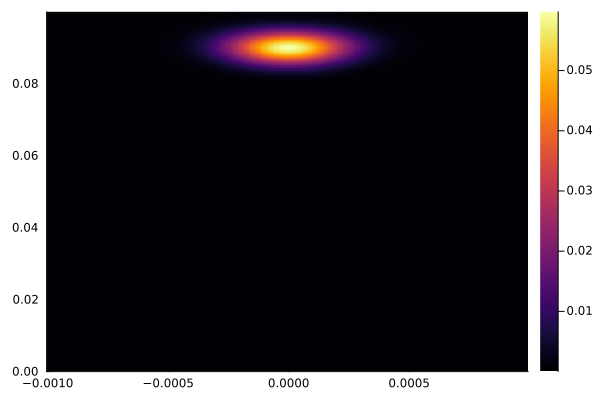

In [298]:
heatmap(Rdomain, Zdomain, AAint, format=:png)

### Setting Initial Conditions to Trixi

Finally we need a variable that will hold the initial conditions to input into `Trixi.jl`

In [315]:
function initial_condition_SVEA(x, t, equations)
    # Amplitude and shift
    
    c = 2.998e8 # speed of light m/s
    eps0 = 8.854e-12 # vacuum permittivity 
    l0 = 1.0e-6 # central wavelength 
    k0 = 2.0*pi/l0 # central wavenumber
    omega0 = c*k0 # central frequency
    
    intensityWcm2 = 1.0e16 # W/cm2
    intensity = intensityWcm2/(0.01^2)
    A0 = 1.0 #sqrt( 2.0*intensity / c / eps0  )

    Znorm = 0.1 #normalization factor
    Rnorm = 0.002 #normalization factor
    Tnorm = Znorm/c
    
    zmin0 = 0.0 #real unnormalized value
    laserzstart = 0.02 #real unnormalized value
    z = x[1]*Znorm # unnormalize our z coordinate by multiplying by Lnorm
    r = x[2]*Rnorm # unnormalize our r coordinate by multiplying by Lnorm
    tt = t*Tnorm # unnormalize our time by multiplying by Tnorm
    

    tfwhm = 25.0e-12 # 1 ns pulsewidth
    rfwhm = 100.0e-6 # 100 micron beamwidht
    tau0 = tfwhm/sqrt(2*log(2))
    w0 = rfwhm/sqrt(2*log(2))
    # println("tau0: ", tau0)
    # println("w0: ", w0)
    
    
    nindexref = 1.0
    zR = pi*nindexref*w0^2/l0
    #normalize beam variables
    w0norm = w0 #/Lnorm
    tau0norm = tau0 #/Tnorm
    zRnorm = zR #/Lnorm
    
    #normalized beam radius, beam curvature, and guoy phase
    wz = w0*sqrt(1 + (z/zR)^2) #w0norm*sqrt(1 + (z/zRnorm)^2)
    # Rz = z * (1 + (zR/z)^2) #z * (1 + (zRnorm/z)^2)
    inv2Rz = 0.5*z/(z^2 + zR^2)
    Guoyz = atan(z/zR) #atan(z/zRnorm)
    
    #Gaussian Beam Amplitude Equation (Complex Valued)
    A = A0 * w0/wz * exp( -r^2/wz^2 ) * exp(1.0im * k0 *r^2*inv2Rz - 1.0im*Guoyz) * exp( -((z - laserzstart)/c - tt)^2/tau0^2  )

    #Derivative in time B = d(A)/dt
    B = A * 2.0*((z - laserzstart)/c - tt)^2/tau0^2

    Ar = real(A)
    Ai = imag(A)
    Br = real(B)
    Bi = imag(B)

    return SVector(Ar, Ai, 0.0, 0.0) #Ar, Ai#
end

initial_condition_SVEA (generic function with 1 method)

First we want to normalize the array holding our r,z coordinates

In [316]:
# Rnorm = 0.002
Zdomainnorm = Zdomain/Znorm
Rdomainnorm = Rdomain/Rnorm;

Let's fill our real `AAAr` and imaginary `AAAi` matrices with the initial conditions

In [317]:
AAAr = zeros(Float64, (length(Zdomain), length(Rdomain)) )
AAAi = zeros(Float64, (length(Zdomain), length(Rdomain)) )

for i in 1:length(Zdomain)
    for j in 1:length(Rdomain)

        AAA = initial_condition_SVEA( [ Zdomainnorm[i], Rdomainnorm[j] ], 0.0, equations_parabolic)
        AAAr[i,j] = AAA[1]
        AAAi[i,j] = AAA[2]
        
    end
end

In [318]:
AAAA = @. AAAr + 1.0im.*AAAi;
AAAA2 = abs2.(AAAA);

In [319]:
# Rdomainnorm = Rdomain./Rnorm
# Zdomainnorm = Zdomain./Znorm;

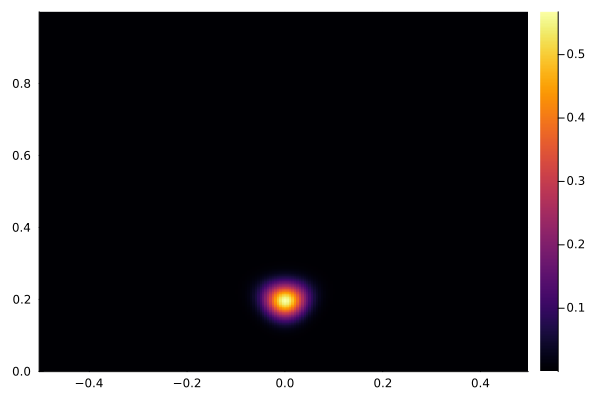

In [320]:
heatmap(Rdomainnorm, Zdomainnorm, AAAA2, format=:png)

## Boundary Conditions: Periodic

For the boundary conditions we will use periodic boundary conditions because that is what is usually done with the Split-Step Fourier Method in solving the Paraxial Wave Equation. 

To use periodic boundary conditions, one does not need to specify a new BC struct as is done in the documentation for the Dirichlet BCs. Instead, periodic BC are implemented when initializing a grid. For example, using the `StructuredMesh()` function we set `periodicity=true` to get periodic BC: 

```
mesh = StructuredMesh(cells_per_dimension,
                coordinates_min, coordinates_max,
                periodicity=true) # set structured mes

```

In [321]:
zdomainnorm, rdomainnorm

([0.0, 1.0], [-0.5, 0.5])

In [322]:
coordinates_min = (zdomainnorm[1], rdomainnorm[1]) # minimum coordinates (min(x), min(y))
coordinates_max = (zdomainnorm[2], rdomainnorm[2]) # maximum coordinates (max(x), max(y))

# cells_per_dimension = (500, 200)
coordinates_min, coordinates_max

((0.0, -0.5), (1.0, 0.5))

We use `TreeMesh()` because it is capable of using the `SemidiscretizationHyperbolicParabolic`

In [324]:
# Create curved mesh with 16 x 16 elements
# mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max, periodicity=true)
mesh = TreeMesh(coordinates_min, coordinates_max, 
                periodicity=true, 
                initial_refinement_level = 6 ,
                n_cells_max = 100_000)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TreeMesh{2, Trixi.SerialTree{2}}                                                                 │
│ ════════════════════════════════                                                                 │
│ center: …………………………………………………………… [0.5, 0.0]                                                       │
│ length: …………………………………………………………… 1.0                                                              │
│ periodicity: ……………………………………………… (true, true)                                                     │
│ current #cells: ……………………………………… 5461                                                             │
│ #leaf-cells: ……………………………………………… 4096                                                             │
│ maximum #cells: ……………………………………… 100000                                                           │
└──────────────────────────────────────────────────────────────────────────────────────────

In [325]:
solver = DGSEM(polydeg=3, surface_flux=flux_lax_friedrichs)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# Semidiscretization

We semidescritize: descritize in space but not in time

We use the `TreeMesh()` because it allows for the use of a hyperbolic-parabolic solver via `SemidiscretizationHyperbolicParabolic`

In [326]:
semi = SemidiscretizationHyperbolicParabolic(mesh,
                                             (equations_hyperbolic, equations_parabolic),
                                             initial_condition_SVEA, solver, source_terms = source_terms_standard )
                                             # boundary_conditions=(boundary_conditions_hyperbolic,
                                             #                      boundary_conditions_parabolic))


┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolicParabolic                                                            │
│ ═════════════════════════════════════                                                            │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 5461                │
│ hyperbolic equations: ……………………… LinearAdvectionEquation4v2D                                      │
│ parabolic equations: ………………………… ConstantAnisotropicDiffusion2D                                   │
│ initial condition: ……………………………… initial_condition_SVEA                                           │
│ source terms: …………………………………………… source_terms_standard                                            │
│ solver: …………………………………………………………… DG                                                       

# ODE Solver

In [333]:
tspan = (0.0, 0.00001/c/Tnorm)
ode = semidiscretize(semi, tspan)
# callbacks = CallbackSet(SummaryCallback())
time_int_tol = 1.0e-6
tspan, Tnorm

((0.0, 9.999999999999999e-5), 3.3355570380253507e-10)

In [334]:
summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 10)
analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)
save_solution = SaveSolutionCallback(interval = 20,
                                     save_initial_solution = true,
                                     save_final_solution = true)
callbacks = CallbackSet(summary_callback, alive_callback, analysis_callback);#,save_solution);


In [335]:
tspan[2]

9.999999999999999e-5

In [ ]:
sol = solve(ode, BS3(); abstol = time_int_tol, reltol = time_int_tol, 
            ode_default_options()..., callback = callbacks)
summary_callback() # print the timer summary

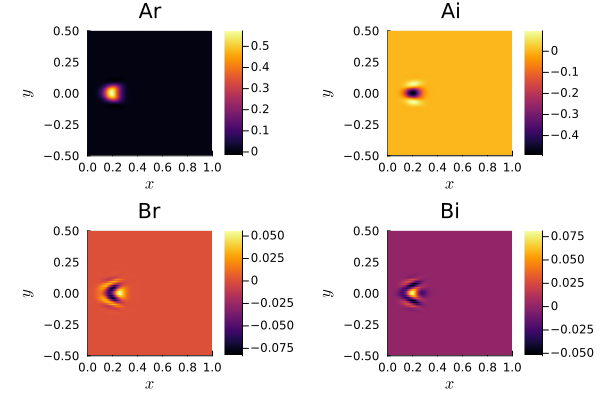

In [337]:
plot(sol, format=:png)

Now no one really understands what the heck is being plotted or how so we need to find a better, more straightforard way to take a look at the data for the solution. 

We use the `Trixi.jl` funciton `PlotData2D` which converts the output of `DifferentialEquations.jl` funciton `sol` into usable data such as 2D matrices for the variables along with x,y coordinates

In [338]:
pd = PlotData2D(sol)

PlotData2DCartesian{Vector{Float64},Vector{Matrix{Float64}},SVector{4, String},Vector{Float64}}(<x>, <y>, <data>, <variable_names>, <mesh_vertices_x>, <mesh_vertices_y>)

Let's get the variable names

In [339]:
pd.variable_names

4-element SVector{4, String} with indices SOneTo(4):
 "Ar"
 "Ai"
 "Br"
 "Bi"

In [340]:
pd.data

4-element Vector{Matrix{Float64}}:
 [8.015179081433013e-58 2.1174184271816042e-57 … 9.643306842572102e-60 8.015179081433013e-58; 5.997041055776189e-58 1.904117932235601e-57 … 2.2783610994724854e-59 5.997041055776189e-58; … ; 5.997041055776246e-58 1.9041179322356043e-57 … 2.278361099472464e-59 5.997041055776246e-58; 8.015179081433013e-58 2.1174184271816042e-57 … 9.643306842572102e-60 8.015179081433013e-58]
 [-1.1205036196221455e-57 -1.6917158178826138e-57 … 4.768503195913747e-59 -1.1205036196221455e-57; -1.411521099295673e-57 -2.3562823093906614e-57 … 5.614480342021764e-59 -1.411521099295673e-57; … ; -1.411521099295667e-57 -2.3562823093906518e-57 … 5.614480342021759e-59 -1.411521099295667e-57; -1.1205036196221455e-57 -1.6917158178826138e-57 … 4.768503195913747e-59 -1.1205036196221455e-57]
 [-2.0739820029231342e-52 -4.9764220556137e-52 … -3.272228379838269e-55 -2.0739820029231342e-52; -3.688507647926645e-52 -8.065124313036759e-52 … -5.909188130352742e-55 -3.688507647926645e-52; … ; -3.68

Now let's actually get the full intensity by adding the real and imaginary parts: $A = A_{r} + i A_{i}$

And squaring the magnitude

In [341]:
Amp = @. pd.data[1] + 1.0im*pd.data[2];
Amp2 = abs2.(Amp);

In [342]:
size(Amp2)

(513, 513)

We can get the coordinates of the data points by using the `PlotData2D` structure's data of `x` and `y`

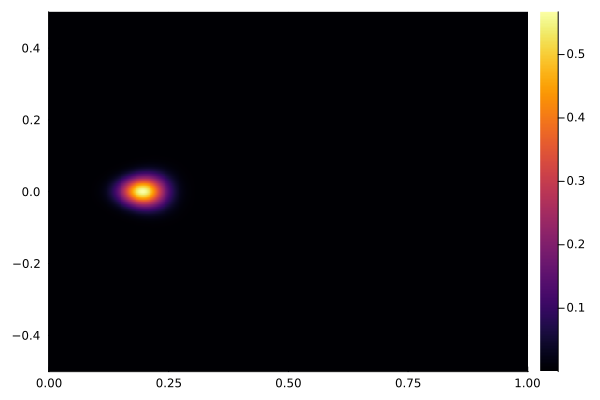

In [344]:
heatmap( pd.x, pd.y,  Amp2, format=:png)
# plot!(ylim=(-0.01,0.01))